In [1]:
do_sim <- function(n_sim = 1000, n_t = 1000, my_garch, df_prices) {
  require(tidyverse)
  require(rugarch)
  
  do_single_sim <- function(i_sim, n_t, my_garch, df_prices) {
    
    
    message('Simulation ', i_sim)
    
    rugarch_sim = ugarchsim(my_garch, n.sim = n_t, 
                            m.sim = 1)
    
    sim_series <- rugarch_sim@simulation$seriesSim
    
    df_sim_out <- tibble(i_sim = i_sim, 
                         i_t = 0:length(sim_series),
                         ref_date = last(df_prices$ref.date) + i_t,
                         sim_log_ret = c(0, sim_series), # model was estimated on log returns
                         sim_arit_ret = exp(sim_log_ret)-1, # use arit return for price calc
                         sim_price = last(df_prices$price.adjusted)*(cumprod(1+sim_arit_ret)) )
    
    return(df_sim_out) 
  }
  
  df_out <- bind_rows(map(.x = 1:n_sim, 
                          .f = do_single_sim, 
                          my_garch = my_garch, 
                          n_t = n_t,
                          df_prices=df_prices))
  
  
}

In [2]:
do_single_garch <- function(x, 
                            type_model, 
                            type_dist, 
                            lag_ar, 
                            lag_ma, 
                            lag_arch, 
                            lag_garch) {
  require(rugarch)
  
  
  spec = ugarchspec(variance.model = list(model =  type_model, 
                                          garchOrder = c(lag_arch, lag_garch)),
                    mean.model = list(armaOrder = c(lag_ar, lag_ma)),
                    distribution = type_dist)
  
  message('Estimating ARMA(',lag_ar, ',', lag_ma,')-',
          type_model, '(', lag_arch, ',', lag_garch, ')', 
          ' dist = ', type_dist,
          appendLF = FALSE)
  
  try({
    my_rugarch <- list()
    my_rugarch <- ugarchfit(spec = spec, data = x)
  })
  
  if (!is.null(coef(my_rugarch))) {
    message('\tDone')
    
    AIC <- rugarch::infocriteria(my_rugarch)[1]
    BIC <- rugarch::infocriteria(my_rugarch)[2]
  } else {
    message('\tEstimation failed..')
    
    AIC <- NA
    BIC <- NA
  }

  est_tab <- tibble(lag_ar, 
                    lag_ma,
                    lag_arch,
                    lag_garch,
                    AIC =  AIC,
                    BIC = BIC,
                    type_model = type_model,
                    type_dist,
                    model_name = paste0('ARMA(', lag_ar, ',', lag_ma, ')+',
                                        type_model, '(', lag_arch, ',', lag_garch, ') ',
                                        type_dist) ) 
  
  return(est_tab)
}

In [3]:
find_best_arch_model <- function(x, 
                                 type_models, 
                                 dist_to_use,
                                 max_lag_AR,
                                 max_lag_MA,
                                 max_lag_ARCH,
                                 max_lag_GARCH) {
  
  require(tidyr)
  
  df_grid <- expand_grid(type_models = type_models,
                         dist_to_use = dist_to_use,
                         arma_lag = 0:max_lag_AR,
                         ma_lag = 0:max_lag_MA,
                         arch_lag = 1:max_lag_ARCH,
                         garch_lag = 1:max_lag_GARCH)
  
  
  l_out <- pmap(.l = list(x = rep(list(x), nrow(df_grid)), 
                          type_model = df_grid$type_models,
                          type_dist = df_grid$dist_to_use,
                          lag_ar = df_grid$arma_lag,
                          lag_ma = df_grid$ma_lag,
                          lag_arch = df_grid$arch_lag,
                          lag_garch  = df_grid$garch_lag),
                do_single_garch)
  
  tab_out <- bind_rows(l_out)
  
  # find by AIC
  idx <- which.min(tab_out$AIC)
  best_aic <- tab_out[idx, ]
  
  # find by BIC
  idx <- which.min(tab_out$BIC)
  best_bic <- tab_out[idx, ]
  
  l_out <- list(best_aic = best_aic,
                best_bic = best_bic,
                tab_out = tab_out)
  
  return(l_out)
}

In [4]:
suppressPackageStartupMessages({library(tidyquant)
library(tidyverse)
})
options(warn = -1)

In [24]:
acao <- "^BVSP"
ibov <- tq_get(acao, from = "2000-01-01")
ret <- ibov %>%
  tq_transmute(select = close, mutate_fun = dailyReturn)
ret_l <- ibov %>%
  tq_transmute(select = close, mutate_fun = dailyReturn, type = "log")
colnames(ret_l) <- c("date", "log_return")
ibov1 <- left_join(ret, ibov, by = c("date" = "date"))
ibov1 <- left_join(ibov1, ret_l, by = c("date" = "date"))
ibov1 <- ibov1 %>%
  group_by(date, symbol) %>%
  summarise(adjusted, log_return, daily.returns) %>%
  mutate(series_name = acao)
colnames(ibov1) <- c("ref.date","ticker","price.adjusted","log_ret","arim_ret","series_name")

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [25]:
arch <- suppressMessages(find_best_arch_model(ibov1$log_ret,
                             type_models = c("sGARCH"),
                             dist_to_use = c("norm"),
                             max_lag_AR = 2,
                             max_lag_MA = 2,
                             max_lag_ARCH = 2,
                             max_lag_GARCH = 2))

In [26]:
lag_ar_best <- arch$best_bic$lag_ar
lag_ma_best <- arch$best_bic$lag_ma
lag_arch_best <- arch$best_bic$lag_arch
lag_garch_best <- arch$best_bic$lag_garch
type <- arch$best_bic$type_model
dist <- arch$best_bic$type_dist

In [27]:
ugspec <- ugarchspec(variance.model = list(model = type,
                                           garchOrder = c(lag_arch_best, lag_garch_best)),
                     mean.model = list(armaOrder = c(lag_ar_best, lag_ma_best)),
                     distribution.model = dist)
ugfit <- ugarchfit(ugspec, ret$daily.returns)

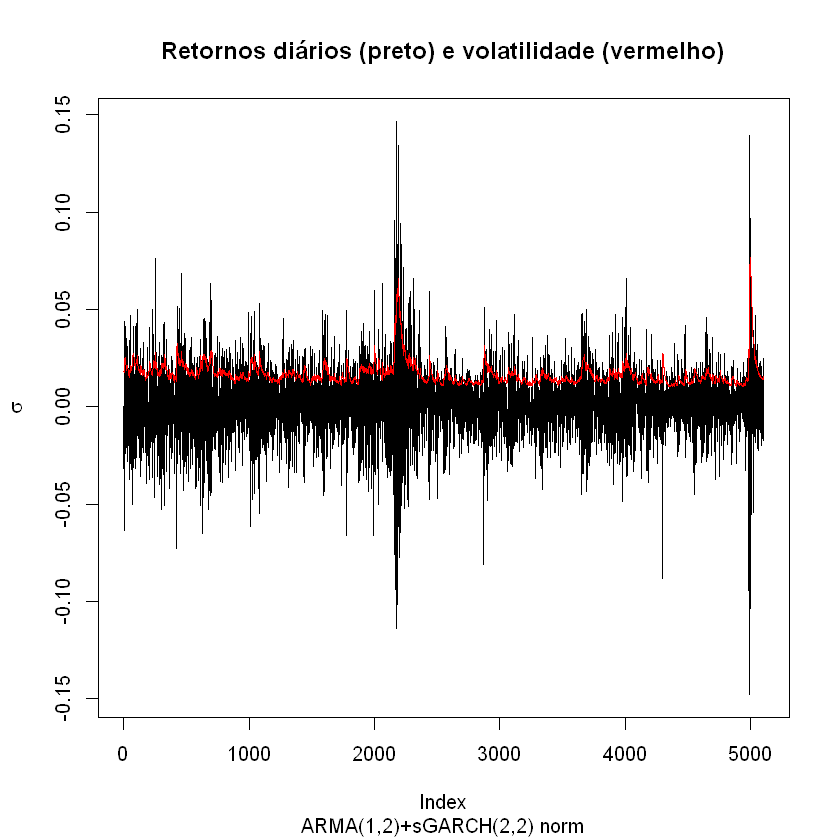

In [28]:
plot(ret$daily.returns, type = "l",
     ylab = expression(sigma),
     main = "Retornos diários (preto) e volatilidade (vermelho)",
    sub = paste(arch$best_aic$model_name))
lines(ugfit@fit$sigma, col = "red")

In [29]:
sim <- suppressMessages(do_sim(n_sim = 5000, n_t = 365, my_garch = ugfit, df_prices = ibov1))

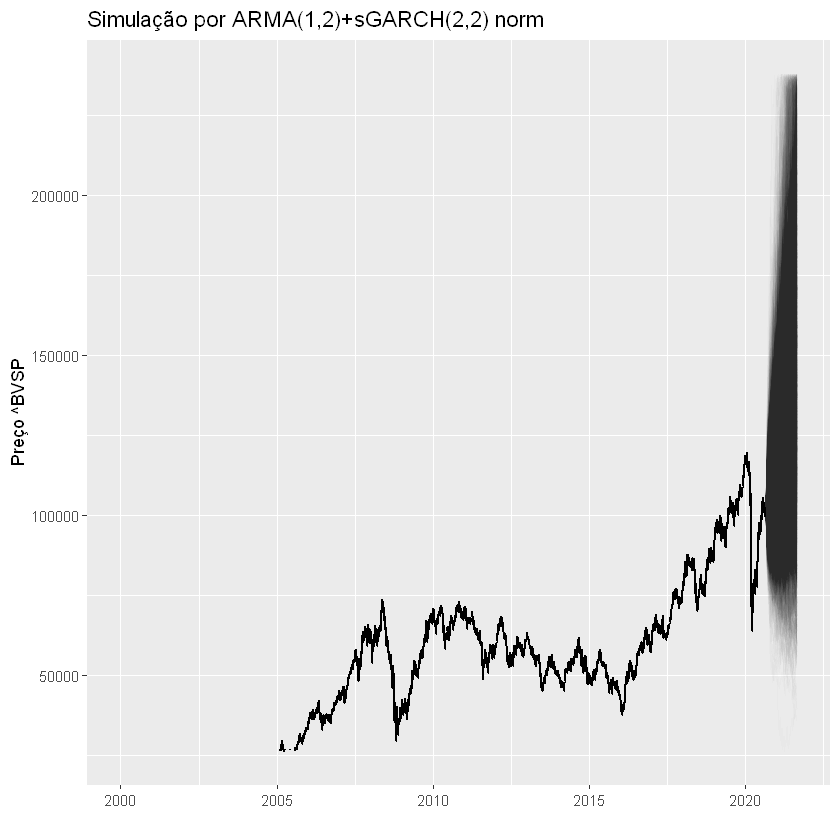

In [30]:
ggplot()+
  geom_line(data = ibov1, mapping = aes(x = ref.date, y = price.adjusted),
            size = 0.75)+
  geom_line(data = sim, mapping = aes(x = ref_date, y = sim_price, group = i_sim),
            size = 0.4,
            alpha = 0.01)+
  labs(x = "", y = paste("Preço", ibov1$series_name),
       title = paste("Simulação por",arch$best_aic$model_name))+
  ylim(min(sim$sim_price),quantile(sim$sim_price,0.99))

In [31]:
meta <- max(ibov1$price.adjusted)
tab_prob <- sim %>%
  group_by(ref_date) %>%
  summarise(prob = mean(sim_price > meta))
p <- tab_prob %>%
  filter(round(prob,2) == 0.5)
p <- p[1,]

`summarise()` ungrouping output (override with `.groups` argument)



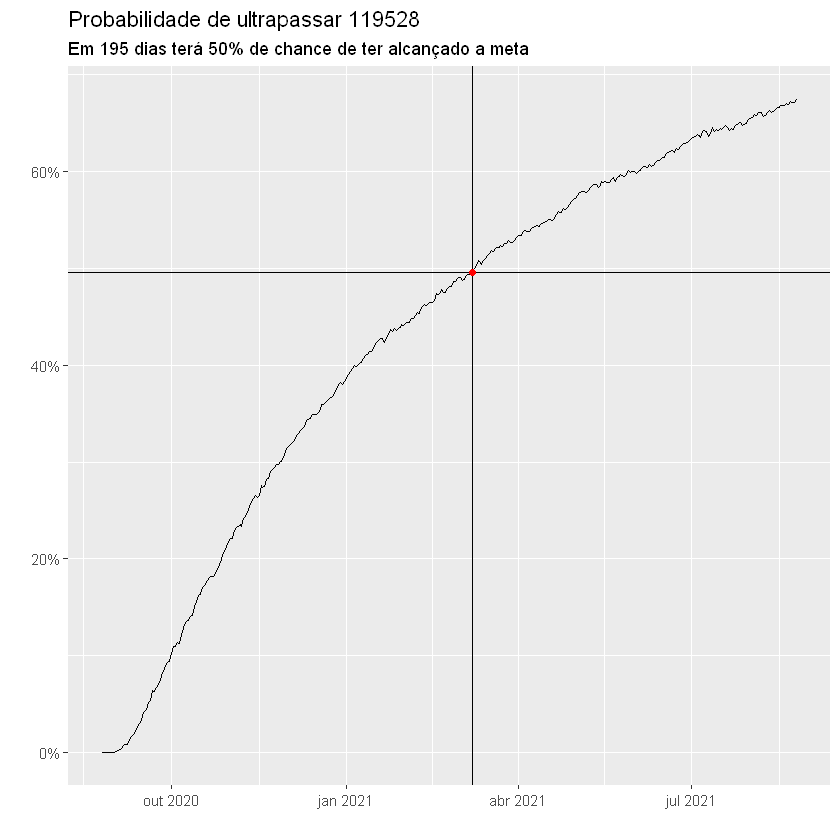

In [32]:
ggplot()+
  geom_line(data = tab_prob[2:nrow(tab_prob),], mapping = aes(x = ref_date, y = prob))+
  labs(x = "", y = "",
       title = paste("Probabilidade de ultrapassar",round(meta,2)),
       subtitle = paste("Em",p$ref_date-last(ibov1$ref.date),
                        "dias terá 50% de chance de ter alcançado a meta"))+
  scale_y_continuous(labels = scales::percent)+
  geom_hline(yintercept = p$prob)+
  geom_vline(xintercept = p$ref_date)+
  geom_point(aes(x = p$ref_date, y = p$prob), col = "red")